In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import feather
import datetime
import itertools
from sklearn import preprocessing
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm
# import optuna.integration.lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
pd.set_option('display.max_Columns', 100)

In [2]:
train = pd.read_csv('../inputs/train.csv')
print(train.shape)
test = pd.read_csv('../inputs/test.csv')
print(test.shape)

(8359, 16)
(8360, 11)


In [3]:
def creansing(df_input):
    df_input['User_Score_tbd'] = (df_input['User_Score'] == 'tbd').astype(int)
    df_input['User_Score'] = df_input['User_Score'].replace({'nan': np.NaN, 'tbd': np.NaN}).astype(float)
    df_input['User_Score_int'] = df_input['User_Score'].round()
    df_input['Critic_Score_int'] = df_input['Critic_Score'].round(-1)/10
    df_input['User_Count_log'] = df_input['User_Count'].apply(np.log1p)
    df_input['Year'] = df_input['Year_of_Release'].fillna(0).round().astype(int)
    df_input.loc[(df_input['Year']>0) & (df_input['Year']<1995), 'Year'] = 1994

In [4]:
creansing(train)
creansing(test)

In [5]:
n_fold = 5

### label_encode

In [6]:
def get_non_overlapping(train: pd.DataFrame, test: pd.DataFrame, column: str):
    """train/testにしか出てこない値を調べる"""
    only_in_train = set(train[column].unique()) - set(test[column].unique())
    only_in_test = set(test[column].unique()) - set(train[column].unique())
    non_overlapping = only_in_train.union(only_in_test)
    return non_overlapping

def category2num(train: pd.DataFrame, test: pd.DataFrame, columns: list):
    train_ = train.copy()
    test_ = test.copy()
    for column in columns:
        non_overlapping = get_non_overlapping(train, test, column)
        try:
            if train[column].dtype == np.dtype("O"):
                # dtypeがobjectなら欠損は'missing' クラスにする
                train_[column] = train[column].fillna("missing")
                test_[column] = test[column].fillna("missing")
                train_[column] = train_[column].map(lambda x: x if x not in non_overlapping else "other")
                test_[column] = test_[column].map(lambda x: x if x not in non_overlapping else "other")
            else:
                # dtypeがint/floatなら欠損は'-1'とする
                train_[column] = train[column].fillna(-1)
                test_[column] = test[column].fillna(-1)
                train_[column] = train_[column].map(lambda x: x if x not in non_overlapping else -2)
                test_[column] = test_[column].map(lambda x: x if x not in non_overlapping else -2)

            le = preprocessing.LabelEncoder()
            concatenated = pd.concat([train_, test_], axis=0).reset_index(drop=True)
            le.fit(concatenated[column])
            train_[column] = le.transform(train_[column])
            test_[column] = le.transform(test_[column])
        except Exception:
            import pdb
            pdb.set_trace()
    return train_, test_

In [7]:
def create_label_encoding(df_train, df_test):
    tr, te = category2num(df_train, df_test, ['Platform', 'Genre', 'Developer', 'Rating'])
    return tr, te

### count_encode

In [8]:
def count_encoding(df_train, df_test, col):
    tr = df_train[col]
    te = df_test[col]
    whole = pd.concat([tr, te])
    vc = whole.value_counts(dropna=False)
    tr_ = pd.DataFrame(tr.map(vc)).add_prefix('CE_')
    te_ = pd.DataFrame(te.map(vc)).add_prefix('CE_')
    return tr_, te_

def create_count_encoding_feature(df_train, df_test):
    tr = pd.DataFrame()
    te = pd.DataFrame()
    for col in ['Platform', 'Genre', 'Publisher', 'Developer', 'Rating', 'User_Score_int', 'Critic_Score_int']:
        tr_, te_ = count_encoding(df_train, df_test, col)
        tr = pd.concat([tr, tr_], axis=1)
        te = pd.concat([te, te_], axis=1)
    return tr, te

### target_encode

In [9]:
def target_encoding(src, dst, group_col, target_col, aggfunc):
    agg_dict = {}
    for tc in target_col:
        agg_dict[tc] = aggfunc
    target = src.groupby(group_col).agg(agg_dict).reset_index()
    
    merge = pd.merge(dst[group_col], target, on=group_col, how='left').set_index(dst.index)
    suffix = '_'.join(group_col)
    return merge.drop(columns=group_col).add_prefix('TGE_').add_suffix('_{}_by_{}'.format(aggfunc, suffix))

In [10]:
def crete_target_enc_train_test(df_train, df_test, group_col, target_col, aggfunc):
    target = pd.DataFrame()
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    for train_index, eval_index in kf.split(df_train):
        kf_train = df_train.iloc[train_index]
        kf_eval = df_train.iloc[eval_index]
        tmp = target_encoding(kf_train, kf_eval, group_col, target_col, aggfunc)
        target = pd.concat([target, tmp])
    # train
    tr = target.sort_index()
    # test
    te = target_encoding(df_train, df_test, group_col, target_col, aggfunc)
    return tr, te

In [11]:
def create_target_encoding_sub(df_train, df_test, tr, te, group, target, aggfunc):
    tr_, te_ = crete_target_enc_train_test(df_train, df_test, group, target, aggfunc)
    tr = pd.concat([tr, tr_], axis=1)
    te = pd.concat([te, te_], axis=1)
    return tr, te

In [12]:
def create_target_encoding(df_train, df_test):
    tr = pd.DataFrame()
    te = pd.DataFrame()
#     target = ['Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
    target = ['Global_Sales']
    groups = [
        ['Platform'],
        ['Genre'],
        ['Rating'],
        ['Year'],
        ['User_Score_int'],
        ['Critic_Score_int'],
        
        ['Platform', 'Genre'],
        ['Platform', 'Rating'],
        ['Platform', 'Year'],
        ['Genre', 'Rating'],
        ['Genre', 'Year'],
        ['Rating', 'Year'],
        
        ['User_Score_int', 'Platform'],
        ['User_Score_int', 'Genre'],
        ['User_Score_int', 'Rating'],
        ['User_Score_int', 'Year'],
        ['Critic_Score_int', 'Platform'],
        ['Critic_Score_int', 'Genre'],
        ['Critic_Score_int', 'Rating'],
        ['Critic_Score_int', 'Year'],
        ['Critic_Score_int', 'User_Score_int'],
    ]
    for gr in groups:
        tr, te = create_target_encoding_sub(df_train, df_test, tr, te, gr, target, 'mean')
    for gr in groups:
        tr, te = create_target_encoding_sub(df_train, df_test, tr, te, gr, target, 'std')
    
    return tr, te

### word (TruncatedSVD)

In [13]:
def word_pivot(df_input, wordlist):
    pivot = pd.DataFrame(index=df_input.index, columns=wordlist)
    pivot = pd.concat([df_input['Name'].str.lower(), pivot], axis=1)
    for c in pivot.columns:
        if c == 'Name':
            continue
        pivot[c] = pivot['Name'].str.contains(c)
    return pivot

In [14]:
def create_wordlist():
    trainName = train['Name'].str.lower()
    testName = test['Name'].str.lower()
    name = pd.concat([trainName, testName]).reset_index(drop=True)
    clean_name = name.str.replace('[^0-9A-Za-z]', ' ')
    
    wordlist = []
    for n in list(clean_name):
        wordlist = wordlist + (str(n).split())
    print(len(wordlist))
    
    df_name = pd.DataFrame(pd.DataFrame(wordlist, columns=['name']).value_counts()).reset_index()
    df_name.rename(columns={0:'name_count'}, inplace=True)
    
    # 3文字以上、3回以上出現している単語
    df_name['word_len'] = df_name['name'].str.len()
    df_longname = df_name[df_name['word_len'] > 3]
    df_longname = df_longname[df_longname['name_count'] > 3]
    
    # 含まれるかどうか
    train_pivot = word_pivot(train, list(df_longname['name']))
    print('train_pivot', train_pivot.shape)
    test_pivot = word_pivot(test, list(df_longname['name']))
    print('test_pivot', test_pivot.shape)
    
    # trainとtestの両方に存在するものだけ(train>3, test>0)
    train_sum = pd.DataFrame(train_pivot.drop(columns=['Name']).sum(), columns=['tr_count'])
    test_sum = pd.DataFrame(test_pivot.drop(columns=['Name']).sum(), columns=['te_count'])
    train_test_sum = pd.concat([train_sum, test_sum], axis=1).reset_index()
    new_wordlist = train_test_sum[(train_test_sum['tr_count']>3)&(train_test_sum['te_count']>0)].reset_index(drop=True)
    
    train_pivot2 = word_pivot(train, list(new_wordlist['index']))
    print('train_pivot2', train_pivot2.shape)
    test_pivot2 = word_pivot(test, list(new_wordlist['index']))
    print('test_pivot2', test_pivot2.shape)
    
    train_pivot2.to_feather('../inputs/train_word.f')
    test_pivot2.to_feather('../inputs/test_word.f')
    
    return train_pivot2, test_pivot2

In [15]:
skip_create_wordlist = True

In [16]:
def create_word_features(df_train, df_test):
    
    if skip_create_wordlist:
        train_word = pd.read_feather('../inputs/train_word.f')
        test_word = pd.read_feather('../inputs/test_word.f')
    else:
        train_word, test_word = create_wordlist()
        
    wd_tr = train_word.drop(columns=['Name']).fillna(0).astype(int).add_prefix('WD_')
    wd_te = test_word.drop(columns=['Name']).fillna(0).astype(int).add_prefix('WD_')
    print('wd_tr', wd_tr.shape)
    print('wd_te', wd_te.shape)
    
    return wd_tr, wd_te

#     svd = TruncatedSVD(5)
#     svd_tr = pd.DataFrame(svd.fit_transform(wd_tr)).add_prefix('SVD_')
#     svd_te = pd.DataFrame(svd.fit_transform(wd_te)).add_prefix('SVD_')
#     print('svd_tr', svd_tr.shape)
#     print('svd_te', svd_te.shape)
    
#     return svd_tr, svd_te
    
#     tr_ = pd.concat([wd_tr, svd_tr], axis=1)
#     te_ = pd.concat([wd_te, svd_te], axis=1)
    
#     return tr_, te_

### LDA

In [17]:
def LDA_topic(df_input, ntopic, index, column):

    df_input['dummy'] = 1
    pvt_tbl = pd.pivot_table(df_input, index=index, columns=column, values='dummy', aggfunc='count')
    pvt_tbl.fillna(0, inplace=True)
    # index ごとに正規化して割合にする
#     pvt_tbl = pvt_tbl.div(pvt_tbl.sum(axis=1), axis=0)
    
    prefix = 'LDA_{}_'.format(column)
    suffix = '_by_{}'.format(index)
    
    lda = LatentDirichletAllocation(n_components=ntopic)
    lda_out = pd.DataFrame(lda.fit_transform(pvt_tbl), index=pvt_tbl.index).add_prefix(prefix).add_suffix(suffix)
    return lda_out.reset_index()

In [18]:
def create_lda_features(df_train, df_test):
    cat_list = ['Platform', 'Genre', 'Developer', 'Rating', 'Publisher']
    tr = df_train[cat_list].copy()
    te = df_test[cat_list].copy()
    whole = pd.concat([tr, te])
    
    for a, b in itertools.permutations(cat_list, 2):
        lda_o = LDA_topic(whole, 5, index=a, column=b)
        tr = pd.merge(tr, lda_o, on=a, how='left')
        te = pd.merge(te, lda_o, on=a, how='left')
        
    return tr.drop(columns=cat_list), te.drop(columns=cat_list)

### salesの割合

In [19]:
sales_columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']

def sales_groupby(df_train, df_test, groupkey):
    tr = df_train[groupkey].copy()
    te = df_test[groupkey].copy()
    grp_sum = df_train[sales_columns].groupby(df_train[groupkey]).sum()
    
    # 列方向の割合
    salescol_sum = grp_sum.sum()
    for c in sales_columns:
        grp_sum['Rate1_'+c] = grp_sum[c] / salescol_sum[c]
    grp_sum.drop(columns=['Rate1_Global_Sales'], inplace=True)
        
    # 行方向の割合
#     for c in sales_columns:
#         grp_sum['Rate2_'+c] = grp_sum[c] / grp_sum['Global_Sales']
#     grp_sum.drop(columns=['Rate2_Global_Sales'], inplace=True)
    
    grp_sum.drop(columns=sales_columns, inplace=True)
    grp_sum = grp_sum.add_suffix('_by_{}'.format(groupkey))

    tr = pd.merge(tr, grp_sum.reset_index(), on=groupkey, how='left').drop(columns=groupkey)
    te = pd.merge(te, grp_sum.reset_index(), on=groupkey, how='left').drop(columns=groupkey)
    return tr, te

In [20]:
def create_sales_feature(df_train, df_test):
    tr = pd.DataFrame(index=df_train.index)
    te = pd.DataFrame(index=df_test.index)
    keys = ['Platform', 'Genre', 'Developer', 'Rating', 'Year']
    for k in keys:
        tr_, te_ = sales_groupby(train, test, k)
        tr = pd.concat([tr, tr_], axis=1)
        te = pd.concat([te, te_], axis=1)
    return tr, te

### 特徴量生成

In [21]:
processors = [
#     create_sales_feature,
    create_count_encoding_feature,
    create_target_encoding,
    create_lda_features,
    create_word_features,
]

In [22]:
def create_feature(train, test):
    train_cp = train.copy()
    test_cp = test.copy()
    
    for func in processors:
        tr, te = func(train_cp, test_cp)
        train_cp = pd.concat([train_cp, tr], axis=1)
        test_cp = pd.concat([test_cp, te], axis=1)

    # label enc
    train_cp, test_cp = create_label_encoding(train_cp, test_cp)
    
    print('train', train_cp.shape)
    print('test', test_cp.shape)
    assert len(train) == len(train_cp)
    assert len(test) == len(test_cp)
    return train_cp, test_cp

In [23]:
train_, test_ = create_feature(train, test)

wd_tr (8359, 1271)
wd_te (8360, 1271)
train (8359, 1441)
test (8360, 1436)


In [24]:
train_.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_tbd,User_Score_int,Critic_Score_int,User_Count_log,Year,CE_Platform,CE_Genre,CE_Publisher,CE_Developer,CE_Rating,CE_User_Score_int,CE_Critic_Score_int,TGE_Global_Sales_mean_by_Platform,TGE_Global_Sales_mean_by_Genre,TGE_Global_Sales_mean_by_Rating,TGE_Global_Sales_mean_by_Year,TGE_Global_Sales_mean_by_User_Score_int,TGE_Global_Sales_mean_by_Critic_Score_int,TGE_Global_Sales_mean_by_Platform_Genre,TGE_Global_Sales_mean_by_Platform_Rating,TGE_Global_Sales_mean_by_Platform_Year,TGE_Global_Sales_mean_by_Genre_Rating,TGE_Global_Sales_mean_by_Genre_Year,TGE_Global_Sales_mean_by_Rating_Year,TGE_Global_Sales_mean_by_User_Score_int_Platform,TGE_Global_Sales_mean_by_User_Score_int_Genre,TGE_Global_Sales_mean_by_User_Score_int_Rating,TGE_Global_Sales_mean_by_User_Score_int_Year,TGE_Global_Sales_mean_by_Critic_Score_int_Platform,TGE_Global_Sales_mean_by_Critic_Score_int_Genre,TGE_Global_Sales_mean_by_Critic_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_Year,TGE_Global_Sales_mean_by_Critic_Score_int_User_Score_int,TGE_Global_Sales_std_by_Platform,...,WD_uchi,WD_coast,WD_akai,WD_forge,WD_civil,WD_flash,WD_festa,WD_fest,WD_explore,WD_times,WD_connect,WD_toshi,WD_alter,WD_eyes,WD_hamster,WD_shock,WD_desu,WD_kami,WD_youkai,WD_saki,WD_drum,WD_loaded,WD_snowboard,WD_roller,WD_main,WD_roku,WD_bout,WD_bound,WD_kill,WD_shiro,WD_shima,WD_kono,WD_runs,WD_mashita,WD_sign,WD_kata,WD_doko,WD_shell,WD_will,WD_limit,WD_cruis,WD_rebel,WD_builder,WD_ippo,WD_split,WD_iris,WD_start,WD_issho,WD_john,WD_michi
0,LEGO Batman: The Videogame,23,NaN,0,Warner Bros. Interactive Entertainment,180,97,0,28,306,74.0,17.0,7.9,22.0,425,1,0,8.0,7.0,3.135494,0,1320,3370,235,77,1420,2830,2019,93.604962,61.883755,49.257785,43.073529,106.536082,49.231678,59.678899,52.633663,61.727273,56.848214,56.571429,74.818182,289.223684,112.428571,64.319444,48.666667,81.140351,48.326531,50.646154,50.583333,56.630137,444.419232,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,LEGO Indiana Jones: The Original Adventures,23,NaN,0,LucasArts,151,61,0,21,234,78.0,22.0,6.6,28.0,425,1,0,7.0,8.0,3.367296,0,1320,3370,90,77,1420,1634,2366,96.597250,58.394680,49.148789,36.985075,66.403374,101.466970,54.090000,48.867470,70.375000,52.439815,51.833333,83.800000,213.160000,54.335079,58.293233,64.250000,483.589744,89.802260,75.231343,56.111111,96.758065,462.863031,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,LEGO Batman: The Videogame,17,NaN,0,Warner Bros. Interactive Entertainment,56,44,0,27,128,73.0,5.0,7.4,10.0,425,1,0,7.0,7.0,2.397895,0,1209,3370,235,77,1420,1634,2019,29.606403,59.681720,53.568595,50.238095,64.981846,46.931655,48.185714,53.033898,24.000000,58.454936,63.607143,94.500000,31.886792,58.615789,60.314286,79.125000,45.701493,47.107692,53.884615,63.545455,57.709821,69.859005,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Combat,0,NaN,0,Atari,117,7,0,1,125,NaN,NaN,NaN,NaN,467,6,0,NaN,NaN,NaN,0,133,3370,367,6623,6769,9129,8582,65.943662,62.435252,NaN,43.041096,NaN,NaN,52.269231,NaN,68.454545,NaN,56.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.197493,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,LEGO Harry Potter: Years 5-7,23,NaN,0,Warner Bros. Interactive Entertainment,69,42,0,12,124,76.0,8.0,7.8,13.0,425,1,0,8.0,8.0,2.639057,0,1320,3370,235,77,1420,2830,2366,96.597250,58.394680,49.148789,36.985075,99.656627,101.466970,54.090000,48.867470,70.375000,52.439815,51.833333,83.800000,284.891892,96.550173,68.844595,64.500000,483.589744,89.802260,75.231343,56.111111,113.766932,462.863031,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [25]:
test_.head()

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_tbd,User_Score_int,Critic_Score_int,User_Count_log,Year,CE_Platform,CE_Genre,CE_Publisher,CE_Developer,CE_Rating,CE_User_Score_int,CE_Critic_Score_int,TGE_Global_Sales_mean_by_Platform,TGE_Global_Sales_mean_by_Genre,TGE_Global_Sales_mean_by_Rating,TGE_Global_Sales_mean_by_Year,TGE_Global_Sales_mean_by_User_Score_int,TGE_Global_Sales_mean_by_Critic_Score_int,TGE_Global_Sales_mean_by_Platform_Genre,TGE_Global_Sales_mean_by_Platform_Rating,TGE_Global_Sales_mean_by_Platform_Year,TGE_Global_Sales_mean_by_Genre_Rating,TGE_Global_Sales_mean_by_Genre_Year,TGE_Global_Sales_mean_by_Rating_Year,TGE_Global_Sales_mean_by_User_Score_int_Platform,TGE_Global_Sales_mean_by_User_Score_int_Genre,TGE_Global_Sales_mean_by_User_Score_int_Rating,TGE_Global_Sales_mean_by_User_Score_int_Year,TGE_Global_Sales_mean_by_Critic_Score_int_Platform,TGE_Global_Sales_mean_by_Critic_Score_int_Genre,TGE_Global_Sales_mean_by_Critic_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_Year,TGE_Global_Sales_mean_by_Critic_Score_int_User_Score_int,TGE_Global_Sales_std_by_Platform,TGE_Global_Sales_std_by_Genre,TGE_Global_Sales_std_by_Rating,TGE_Global_Sales_std_by_Year,TGE_Global_Sales_std_by_User_Score_int,TGE_Global_Sales_std_by_Critic_Score_int,...,WD_uchi,WD_coast,WD_akai,WD_forge,WD_civil,WD_flash,WD_festa,WD_fest,WD_explore,WD_times,WD_connect,WD_toshi,WD_alter,WD_eyes,WD_hamster,WD_shock,WD_desu,WD_kami,WD_youkai,WD_saki,WD_drum,WD_loaded,WD_snowboard,WD_roller,WD_main,WD_roku,WD_bout,WD_bound,WD_kill,WD_shiro,WD_shima,WD_kono,WD_runs,WD_mashita,WD_sign,WD_kata,WD_doko,WD_shell,WD_will,WD_limit,WD_cruis,WD_rebel,WD_builder,WD_ippo,WD_split,WD_iris,WD_start,WD_issho,WD_john,WD_michi
0,Hitman 2: Silent Assassin,26,NaN,0,Eidos Interactive,84.0,23.0,8.0,19.0,216,3,0,8.0,8.0,2.995732,0,824,3370,198,20,1563,2830,2366,28.428571,61.011474,96.410622,44.047619,100.864791,99.177204,25.973684,50.600000,20.000000,118.701987,60.294118,52.125000,40.721649,103.318681,123.796512,65.428571,34.246377,90.017778,88.489083,79.833333,111.091346,64.594512,139.218459,203.600983,57.863759,320.473808,323.717868,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Legacy of Kain: Soul Reaver,13,NaN,0,Eidos Interactive,91.0,17.0,9.0,132.0,112,5,0,9.0,9.0,4.890349,0,1197,3370,198,25,2961,1033,760,72.632812,61.011474,50.841880,44.047619,126.789762,201.134986,72.709091,230.451613,NaN,51.920228,60.294118,32.842105,325.000000,156.375000,104.608491,31.000000,412.666667,190.612903,164.576923,35.600000,215.804348,129.886997,139.218459,99.850190,57.863759,235.111932,327.145440,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Metal Gear Solid 2: Substance,26,NaN,0,Konami Digital Entertainment,87.0,28.0,8.5,39.0,469,3,0,8.0,9.0,3.688879,0,824,3370,834,12,1563,2830,760,28.428571,61.011474,96.410622,44.047619,100.864791,201.134986,25.973684,50.600000,20.000000,118.701987,60.294118,52.125000,40.721649,103.318681,123.796512,65.428571,57.935484,190.612903,201.981308,35.600000,201.214689,64.594512,139.218459,203.600983,57.863759,320.473808,327.145440,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Silent Hill: Homecoming,25,NaN,0,Konami Digital Entertainment,70.0,54.0,6.9,180.0,134,3,0,7.0,7.0,5.198497,0,1262,3370,834,22,1563,1634,2019,81.399660,61.011474,96.410622,44.047619,66.212871,48.703390,82.083333,150.326531,40.100000,118.701987,60.294118,52.125000,73.521368,55.267241,56.746753,84.555556,63.443299,47.967078,43.502703,62.866667,60.283688,176.257783,139.218459,203.600983,57.863759,166.455204,77.728797,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Silent Hill: Homecoming,15,NaN,0,Konami Digital Entertainment,71.0,41.0,6.9,143.0,134,3,0,7.0,7.0,4.96981

In [26]:
lgbm_param = {
    'objective' : 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'seed' : 0,
    'learning_rate':  0.1,
    'max_depth': 6,
    'colsample_bytree': .5,
    'importance_type': 'gain'
}

In [27]:
def tuning_lgbm(X, y, group, params, verbose=100):
    unique_group = group.unique()
    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = fold.split(unique_group)
    tr_group_idx, va_group_idx = list(cv)[0]
        
    train_groups = unique_group[tr_group_idx]
    valid_groups = unique_group[va_group_idx]
    is_train = group.isin(train_groups)
    is_valid = group.isin(valid_groups)
        
    x_train, y_train = X[is_train], y[is_train]
    x_valid, y_valid = X[is_valid], y[is_valid]
    
    lgbm_train = lgbm.Dataset(x_train, y_train)
    lgbm_eval = lgbm.Dataset(x_valid, y_valid, reference=lgbm_train)
    
    best_params, tuning_history = dict(), list()
    best = lgbm.train(params,
                                  lgbm_train,
                                  valid_sets=lgbm_eval,
                                  num_boost_round=10000,
                                  early_stopping_rounds=verbose,
                                  verbose_eval=0)
    print('Best Params:', best.params)
    print('Best Iteration:', best.best_iteration)
    print('Best Score:', best.best_score)

In [28]:
# %%time
# y = train_['Global_Sales'].apply(np.log1p)
# group = train_['Publisher'].copy()
# train_.drop(columns=['Name', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], inplace=True)

# tuning_lgbm(train_, y, group, lgbm_param)

In [29]:
def train_lgbm(X, y, group, params: dict, verbose=100):

    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = list(fold.split(X)) 
    
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        
        lgbm_train = lgbm.Dataset(x_train, y_train)
        lgbm_eval = lgbm.Dataset(x_valid, y_valid, reference=lgbm_train)
        
        lgbm_model = lgbm.train(params, 
                                                    lgbm_train, 
                                                    valid_sets=lgbm_eval,
                                                    num_boost_round=10000,
                                                    early_stopping_rounds=verbose,
                                                    verbose_eval=verbose)
        y_pred = lgbm_model.predict(x_valid, num_iteration=lgbm_model.best_iteration)
        
        oof_pred[idx_valid] = y_pred
        models.append(lgbm_model)
        print('Fold {} Score: {:.4f}'.format(i, np.sqrt(mean_squared_error(y_valid, y_pred))))

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models, score

In [30]:
def train_lgbm_group(X, y, group, params: dict, verbose=100):

    unique_group = group.unique()
    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = fold.split(unique_group)
    
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (tr_group_idx, va_group_idx) in enumerate(cv):
        
        train_groups = unique_group[tr_group_idx]
        valid_groups = unique_group[va_group_idx]
        is_train = group.isin(train_groups)
        is_valid = group.isin(valid_groups)
        
        x_train, y_train = X[is_train], y[is_train]
        x_valid, y_valid = X[is_valid], y[is_valid]
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        
        lgbm_train = lgbm.Dataset(x_train, y_train)
        lgbm_eval = lgbm.Dataset(x_valid, y_valid, reference=lgbm_train)
        
        lgbm_model = lgbm.train(params, 
                                                    lgbm_train, 
                                                    valid_sets=lgbm_eval,
                                                    num_boost_round=10000,
                                                    early_stopping_rounds=verbose,
                                                    verbose_eval=verbose)
        y_pred = lgbm_model.predict(x_valid, num_iteration=lgbm_model.best_iteration)
        
        oof_pred[is_valid] = y_pred
        models.append(lgbm_model)
        print('Fold {} Score: {:.4f}'.format(i, np.sqrt(mean_squared_error(y_valid, y_pred))))

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models, score

In [31]:
def train_pred(train_df, y, test_df, group):
    oof, models, score = train_lgbm_group(train_df, y, group, lgbm_param)
    
    pred_list = []
    for model in models:
            pred = model.predict(test_df, num_iteration = model.best_iteration)
            pred = np.expm1(pred)
            pred_list.append(pred)
            print(pred.mean())
            
    pred = np.mean(pred_list, axis=0)
    return pred, score, models

In [32]:
def feat_imp(model):
    fi = model.feature_importance()
    fn = model.feature_name()
    df_feature_importance = pd.DataFrame({'name':fn, 'imp':fi})
    df_feature_importance.sort_values('imp', inplace=True)
    return df_feature_importance

def feature_importance(models):
    fi = pd.DataFrame(columns=['name'])
    for i, model in enumerate(models):
        fi_tmp = feat_imp(model)
        colname = 'imp_{}'.format(i)
        fi_tmp.rename(columns={'imp': colname}, inplace=True)
        fi = pd.merge(fi, fi_tmp, on=['name'], how='outer')
    fi['sum'] = fi.sum(axis=1)
    return fi.sort_values(['sum'], ascending=False)

In [33]:
%%time
y = train_['Global_Sales'].apply(np.log1p)
group = train_['Publisher'].copy()
train_.drop(columns=['Name', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], inplace=True)
test_.drop(columns=['Name', 'Publisher',], inplace=True)
column_cnt = len(train_.columns)
assert train_.shape[1] == test_.shape[1]

pred, score, models = train_pred(train_, y, test_, group)

x_train (6174, 1434)
x_valid (2185, 1434)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.31787
Early stopping, best iteration is:
[72]	valid_0's rmse: 1.31135
Fold 0 Score: 1.3114
x_train (7540, 1434)
x_valid (819, 1434)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.895371
[200]	valid_0's rmse: 0.891755
[300]	valid_0's rmse: 0.892274
Early stopping, best iteration is:
[257]	valid_0's rmse: 0.889012
Fold 1 Score: 0.8890
x_train (5807, 1434)
x_valid (2552, 1434)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.957046
[200]	valid_0's rmse: 0.949316
[300]	valid_0's rmse: 0.950109
Early stopping, best iteration is:
[263]	valid_0's rmse: 0.948682
Fold 2 Score: 0.9487
x_train (6856, 1434)
x_valid (1503, 1434)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.954743
Early stopping, best iteration is:
[99]	valid_0's rmse: 0.954521
Fold 3 Score: 

In [34]:
feature_importance(models).head(50)

,name,imp_0,imp_1,imp_2,imp_3,imp_4,sum
1432,Year_of_Release,57,99,125,54,76,411
1433,User_Count,69,89,87,90,68,403
1431,TGE_Global_Sales_mean_by_Platform_Year,45,96,102,39,53,335
1428,TGE_Global_Sales_mean_by_Platform_Genre,28,102,81,25,54,290
1425,User_Count_log,25,62,66,24,54,231
1414,TGE_Global_Sales_mean_by_Genre_Year,18,56,82,33,38,227
1423,TGE_Global_Sales_std_by_Genre_Year,23,85,66,25,24,223
1420,TGE_Global_Sales_std_by_Platform_Genre,20,79,66,30,22,217
1412,TGE_Global_Sales_std_by_Platform_Year,18,74,55,29,34,210
1356,LDA_Platform_1_by_Publisher,8,58,67,31,40,204


In [35]:
df_pred = pd.DataFrame(pred, columns=['Global_Sales'])
df_pred.loc[df_pred['Global_Sales'] < 1, 'Global_Sales'] = 0
print(df_pred.shape)
pred_mean = df_pred['Global_Sales'].mean()
pred_max = df_pred['Global_Sales'].max()
print('mean=', pred_mean)
print('max=', pred_max)
assert len(df_pred) == len(test)

(8360, 1)
mean= 23.63744378637965
max= 471.798264346152


Text(0.5, 0, 'Global_Sales')

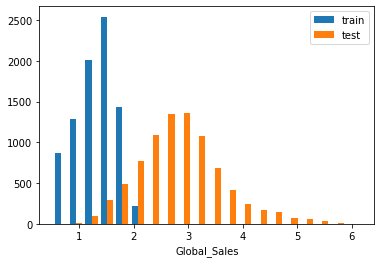

In [36]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist([np.log1p(y), np.log1p(df_pred['Global_Sales'])], bins=20, label=['train', 'test'])
ax.legend()
ax.set_xlabel('Global_Sales')

In [37]:
FILENAME = 'submission.csv'
OUTPUT_DIR = '../outputs/'
filepath = os.path.join(OUTPUT_DIR, FILENAME)
df_pred.to_csv(filepath, index=False)
print(filepath)

../outputs/submission.csv


In [38]:
print('- feat =', column_cnt)
print('- mean = {:.4f}'.format(pred_mean))
print('- max = {:.4f}'.format(pred_max))
print('- score = {:.4f}'.format(score))

- feat = 1434
- mean = 23.6374
- max = 471.7983
- score = 1.0538


#### 15: Yearカテゴリ(TGEのみ)
- feat = 1434
- mean = 23.6374
- max = 471.7983
- score = 1.0538
- LB= 0.9192

#### 14: Yearカテゴリ(TGE, CE, LDA)
- feat = 1485
- mean = 26.5035
- max = 478.8022
- score = 1.0946
- LB= 0.9053

#### 13: salesの割合(列方向のみ)
- feat = 1442
- mean = 18.6484
- max = 250.7313
- score = 1.0221
- LB= 1.0443

#### 12: salesの割合
- feat = 1462
- mean = 17.3735
- max = 342.4879
- score = 1.0254
- LB= 1.0596

#### 11: target_encでUser_Score/Critic_Score
- feat = 1420
- mean = 23.8047
- max = 489.9664
- score = 1.0795
- LB= 0.9001　★best★

#### 10: target_encのstd
- feat = 1406
- mean = 26.6392
- max = 520.2849
- score = 1.0827
- LB= 0.9013

#### 9: categoryのLDA
- feat = 1398
- mean = 23.8993
- max = 486.8888
- score = 1.0477
- LB= 0.9182

#### 8: word(1271)+TSVD(30)
- feat = 1328
- mean = 31.0632
- max = 466.2990
- score = 1.0276
- LB= 0.954

#### 7: target_enc (Global_Salesのみ, group追加)
- feat = 2476
- mean = 31.4078
- max = 579.2456
- score = 1.0236
- LB= 0.9326

#### 6: TruncatedSVD(1000)
- feat = 1044
- mean = 32.0386
- max = 395.4888
- score = 1.0436
- LB= 0.9639

#### 5: TruncatedSVD(500)
- feat = 544
- mean = 31.0907
- max = 388.7002
- score = 1.0476
- LB= 0.9661

#### 4-2: tuning
- feat = 2493
- mean = 34.8119
- max = 602.9193
- score = 1.0144
- LB= 0.9482

#### 4-1: hyper-param
- feat = 2493
- mean = 31.2463
- max = 569.0352
- score = 1.0288
- LB= 0.9343

#### 4: groupKfold
- feat = 2493
- mean = 31.4331
- max = 586.5045
- score = 1.0276
- LB= 0.9369

#### 3: word
- feat = 2493
- mean = 31.4031
- max = 719.7462
- score = 0.8767
- LB= 0.9438

#### 2: target_enc
- feat = 31
- mean = 33.8397
- max = 954.7167
- score = 0.9164
- LB= 0.9535

#### 1: first
- feat = 16
- mean = 35.8113
- max = 955.3011
- score = 0.9007
- LB= 0.9763

#### 4-2
```
Best Params: {
    'objective': 'regression', 
    'boosting_type': 'gbdt', 
    'metric': 'rmse', 
    'seed': 0, 
    'learning_rate': 0.1, 
    'lambda_l1': 5.792555549718162e-07, 
    'lambda_l2': 9.746574164893419, 
    'num_leaves': 8, 
    'feature_fraction': 0.41600000000000004, 
    'bagging_fraction': 0.4048568269728143, 
    'bagging_freq': 3, 
    'min_child_samples': 50
}
Best Iteration: 244
```